In [1]:
import rdflib
from rdflib import URIRef
from rdflib.graph import ConjunctiveGraph
g = ConjunctiveGraph()

In [2]:
import pandas as pd
import json
from SPARQLWrapper import SPARQLWrapper, XML, JSON
from rdflib import Graph

In [3]:
def get_sparql_dataframe(service, query):
    #Helper function to convert SPARQL results into a pandas data frame
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()
    
    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    
    out =[]
    for row in processed_results['results']['bindings']:
        item =[]
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
    return pd.DataFrame(out, columns=cols)

In [4]:
wds = "http://dbpedia.org/sparql"

In [5]:
rq =""" 
PREFIX  dbpedia-owl:  <http://dbpedia.org/ontology/>
PREFIX dbpedia: <http://dbpedia.org/resource>
PREFIX dbpprop: <http://dbpedia.org/property>
PREFIX cat: <http://dbpedia.org/resource/Category:>
PREFIX dbp: <http://dbpedia.org/property/owner>

SELECT  DISTINCT ?company_name ?Key_Person ?product ?type_ck
WHERE {
   ?company dct:subject cat:Retail_companies_of_the_United_Kingdom.
   ?company dct:subject ?subject.
   ?company rdfs:label ?company_name.
   ?company dbo:keyPerson ?keyPerson.
   ?keyPerson rdfs:label ?Key_Person.
   ?company dbo:product ?dboproduct.
   ?dboproduct rdfs:label ?product.
   ?company dbo:type ?type.
   ?type rdfs:label ?type_ck.
   FILTER ( lang(?company_name) = 'en' and lang(?Key_Person) = 'en' and lang(?product) = 'en' and lang(?type_ck) = 'en')
}

GROUP BY ?company
"""

In [6]:
df = get_sparql_dataframe(wds,rq)

In [7]:
df.shape

(137, 4)

In [8]:
df.head(5)

,company_name,Key_Person,product,type_ck
0,Tesco,Dave Lewis (businessman),Big-box store,Public limited company
1,JD Sports,Chairman,Sportswear (activewear),Public limited company
2,Morrisons,Ken Morrison,Supermarket,Public limited company
3,Carphone Warehouse,Charles Dunstone,Service (economics),Private limited company
4,Carphone Warehouse,Chief Executive,Landline phone,Private limited company


In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
from pyvis import network as net

In [25]:
df1 = df[['company_name', 'product']]
df1['edge_label'] = "product"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df2 = df[['Key_Person', 'company_name']]
df2['edge_label'] = "key_person"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
df3 = df[['company_name', 'type_ck']]
df3['edge_label'] = "type"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
df1.columns = ['source', 'target', 'edge_label']
df2.columns = ['source', 'target', 'edge_label']
df3.columns = ['source', 'target', 'edge_label']

In [47]:
df4 = df1.append(df2)
df5 = df4.append(df3)

df5.to_csv("store_data.csv")

In [30]:
# Build your graph. Note that we use the DiGraph function to create the graph!
G=nx.from_pandas_edgelist(df5, 'source', 'target', create_using=nx.DiGraph() )

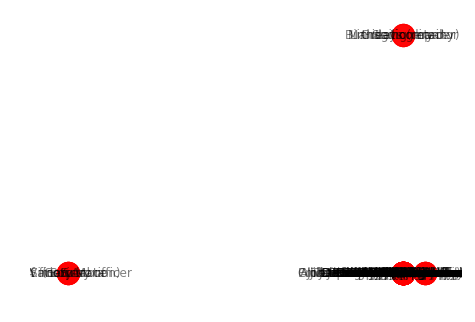

In [46]:
# Make the graph
g=net.Network(notebook=True)
nx.draw_spectral(G, with_labels=True, node_size=500, alpha=0.5, arrows=True)
g.from_nx(G)
g.show("example.html")

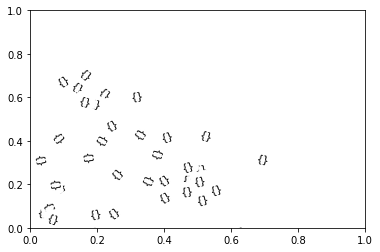

In [35]:
import networkx as nx

from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4

# Prepare Data
#G = nx.karate_club_graph()

# Show with Bokeh
plot = Plot(plot_width=900, plot_height=900, x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Knowledge Graph of UK Supermarket"
edge_labels=nx.draw_networkx_edge_labels(G,pos=nx.spring_layout(G))
node_hover_tool = HoverTool(tooltips=[("store", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.kamada_kawai_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=50, fill_color="grey")
graph_renderer.edge_renderer.glyph = MultiLine(line_color="green", line_alpha=1, line_width=1)
plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)

Loading BokehJS ...

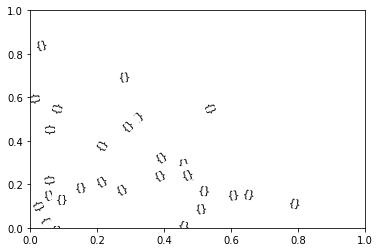

In [34]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.models.graphs import from_networkx
output_notebook()

plot = figure(title="Karate Club Graph", tools="", x_range=(-1.5, 1.5),
          y_range=(-1.5, 1.5), toolbar_location=None)
graph = from_networkx(G, nx.spring_layout)
plot.renderers.append(graph)

edge_labels=nx.draw_networkx_edge_labels(G,pos=nx.spring_layout(G))